# Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# df = pd.read_csv("/content/sample_data/churn_data.csv")
df = pd.read_csv("churn_data.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
# распределение классов
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные масштабируем при помощи StandardScaler
- Денежные признаки по рекомендации с урока прологарифмируем

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class LogTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log(X + 1)

Зададим списки признаков

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'NumOfProducts']
finance_columns = ['Balance', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('std', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for fin_col in finance_columns:
    fin_transformer = Pipeline([
                ('selector', NumberSelector(key=fin_col)),
                ('log', LogTransform())
            ])
    final_transformers.append((fin_col, fin_transformer))

Объединим все это в единый пайплайн

In [8]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [9]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Сделаем поиск оптимальных параметров

In [10]:
params={'classifier__n_estimators':[250, 300, 400],
        'classifier__min_samples_leaf':[2, 3],
        'classifier__max_depth':[3, 4, 100]
        }

grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False,
                   scoring='f1')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 100,
 'classifier__min_samples_leaf': 2,
 'classifier__n_estimators': 250}

Обучим модель c найденными параметрами

In [11]:
# Докрутим вручную гиперпапаметры
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,
                                          min_samples_leaf=2, 
                                          n_estimators=350,
                                          max_depth=100)),
])

#обучим пайплайн
pipeline.fit(X_train, y_train)

#прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.379455, F-Score=0.663, Precision=0.702, Recall=0.629


### Опробуем модель бустинга

In [12]:
pipeline_boost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

#обучим наш пайплайн
pipeline_boost.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = pipeline_boost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


### Найдем оптимальные параметры для бустинга

In [13]:
params={'classifier__n_estimators':[100, 200, 300],
        'classifier__min_samples_leaf':[5, 10],
        'classifier__max_depth':[2, 3, 4]
        }

grid = GridSearchCV(pipeline_boost,
                    param_grid=params,
                    cv=6,
                    refit=False,
                   scoring='f1')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 300}

### Обучим модель бустинга с оптимальными параметрами

In [14]:
# Докрутим вручную гиперпапаметры
pipeline_boost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42,
                                              min_samples_leaf=10, 
                                              n_estimators=200,
                                              max_depth=3)),
])

#обучим наш пайплайн
pipeline_boost.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = pipeline_boost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.383536, F-Score=0.654, Precision=0.679, Recall=0.631


### Опробуем логистическую регрессиию

In [15]:
pipeline_logr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

#обучим наш пайплайн
pipeline_logr.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = pipeline_logr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.257347, F-Score=0.503, Precision=0.422, Recall=0.623


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 2. Отберем лучшую модель
На основе проведенных экспериметов видим лучшие показатели у модели RandomForest

Если не принимать во внимание сколько стоит привлечение новых клиентов и удержание старых, то для оттока лучше использовать f1 метрику, т.к. необходим балланс между точностью и полнотой.

## 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.


Отрисуем матрицу ошибок

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1855  136]
 [ 190  319]]


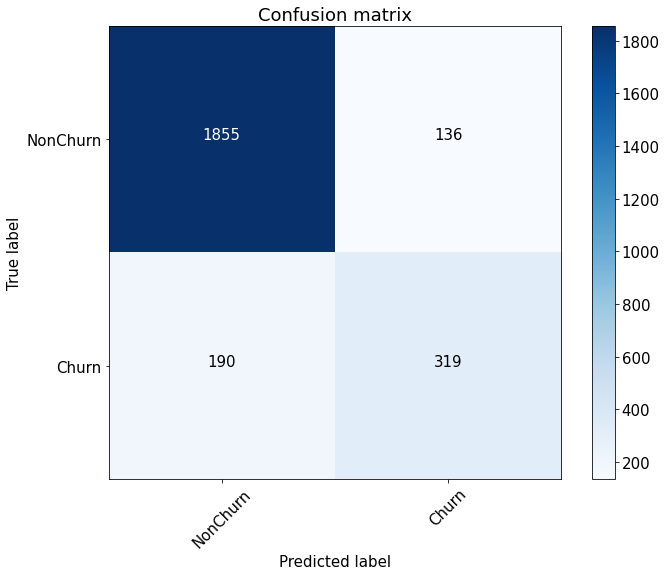

In [17]:
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Получается что в отток не ушли 1855 - TP
В отток реально ушли 319 - TN
При этом 136 наша ошибка, что они ушли и вероятно их удалось удержать - FN
При этом 190 это так же ушли в отток и мы их ложно классифицировали как оставшихся.

Если смотреть в рамках проведения рекламмной компании, то фактически мы можем не считая все прибыли понимать ее эффективность в часати минимизации потерь. И раскалад здесь может быть следующим:
Получатеся, что у нас реально ушло 319+190, а значит затраты на них были (319+190)*1=509 Это фактически мы потеряли
При этом выгода от рекламмной компании 136*2 = 272, здесь видно, что затраты на рекламмную компанию по соотношению ушедших / удержанных не эффективна.
Однако, если учитывать, что мы знали про 319 уходящих и не тратили на них деньги, то в этом случае так же реклама осталась не эффективна, хоть и в меньших показателях. (190+136)*1 - 136*2 = 326 - 272 = -54.
Но в целом экономическая модель с учетом общей прибыли от 1855*2 = 3710 и затраченным средствам на рекламу в размере 509 рабочая и приносит выгоду.